# Диффузионные модели

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/puhsu/dl-hse/tree/main/2024/hw04-bonus-diffusion/notebook.ipynb)

#### Разработчик: Аким Котельников

План задания: пишем свою диффузионную модель и тестируем её на SwissRoll-ах (60% баллов), далее запускаем её на MNIST (20%), затем пишем DDIM и проверям его на MNIST (20%). Цель задания: разобраться как работают диффузионные модели, разобраться в формулах. При этом проблем с обучением моделей почти быть не должно. Формат: дозаполнить "todo".

### Импорты и SwissRoll-ы

In [1]:
# !wget --quiet --show-progress "https://raw.githubusercontent.com/puhsu/dl-hse/main/2024/hw04-bonus-diffusion/utils.py"

In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import math

import torch
import torch.nn as nn


class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding     

class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=128):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)
        self.y_embed = nn.Embedding(10, time_emb_dim)
        self.is_y_cond = True

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t, y):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t) 
        if self.is_y_cond:
            t += self.y_embed(y)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )


In [2]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle

In [3]:
SEED = 777

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
from sklearn.datasets import make_circles, make_swiss_roll


def make_swiss_dataset(num_samples):
    X0, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X1, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X0 = X0[:, [0, 2]]
    X1 = X1[:, [0, 2]]
    X1 = -X1
    X, y = shuffle(
        np.concatenate([X0, X1], axis=0),
        np.concatenate([np.zeros(len(X0)), np.ones(len(X1))], axis=0),
        random_state=0,
    )
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    return X, y


X, y = make_swiss_dataset(2000)

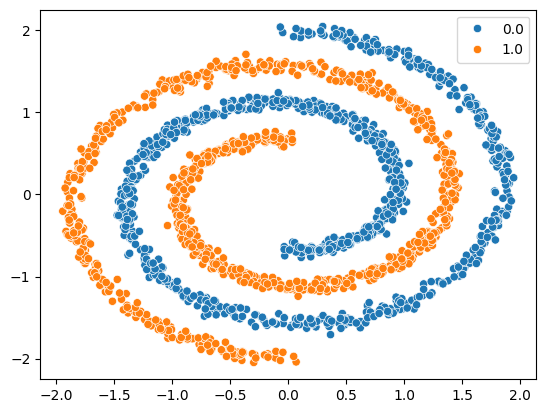

In [5]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

## DDPM (0.6 баллов)

В данной части вам предстоит написать собстевнную диффузионную модель (DDPM) и протестировать её на датасете выше.

### Напоминание

Напомним, что диффузионная модель состоит из прямого и обратного процесса. Прямой диффузионный процесс определяется как апостериорное распределение $q(x_{1:T}|x_0)$. Это распределение также является Марковской цепочкой, которая постепенно добавляет гауссовский шум к данному начальному объекту $x_0$. На каждом шаге шум добавляется с различной магнитудой, которая определяется расписанием дисперсий
 $\{\beta_1, ... \beta_T\}$. При правильном выборе расписания в пределе по числу шагов $T$ мы должны сойтись к шуму из $\mathcal{N}(0, I)$. В качестве распределений $q$ берут нормальные распределения:
$$
 q(x_t | x_{t - 1}) := \mathcal{N}(x_t; \sqrt{1 - \beta_t}x_{t - 1}, \beta_tI), \ \ \ \ \ \ \ q(x_{1:T}|x_0) = \prod_{t = 1}^T q(x_t | x_{t - 1})
$$

Теперь посмотрим со стороны обратного процесса. Обратный процесс расшумляет шум, пока не получится объект из изначального распределения. Таким образом, диффузионная модель - это вероятностная модель с латентными переменными вида $p_\theta(x_0) := \int p_\theta(x_{0:T}) dx_{1:T}$, где промежуточные состояния $x_1, ..., x_T$ соответствуют зашумленным объектам, a $x_0$ - объект из распределения. Совместное распределение $p_\theta(x_{0:T})$ называет обратным диффузионным процессом, который представляет собой Марковскую цепочку из гауссовских распределений $p_\theta(x_{i-1}|x_{i})$:

$$
p(x_{0:T}) = p(x_0) \prod_{t = 1}^Tp_{\theta}(x_{t-1}|x_t) \ \ \ \ \ \ \ \ \ p_\theta(x_{T})=\mathcal{N}(x_T | 0, I)
$$
$$
  p_{\theta}(x_{t - 1}|x_t):= \mathcal{N}(x_{t - 1}; \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t))
$$

Вернемся к распределению $q(x_t | x_{t - 1})$.  Для того чтобы получить $x_t$, придется итеративно получать $x_1, ..., x_{t - 1}$. Однако это можно сделать более эффективно благодаря нормальным распределениям. Для этого обозначим $\alpha_t := 1- \beta_t$ и $\bar{\alpha}_t:= \prod_{i = 1}^t\alpha_i$, тогда
$$
q(x_t | x_0) = \mathcal{N}(x_t;\sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t)I) \quad \quad \quad \quad \quad \quad (1)
$$

Затем модель можно обучать, оптимизируя отдельные члены суммы вариационной нижней оценки $\log p_{\theta}(x_0)$:
$$
L_{VLB} = \mathbb{E}_q [\underbrace{D_\text{KL}(q(\mathbf{x}_T |
\mathbf{x}_0) \parallel p_\theta(\mathbf{x}_T))}_{L_T} + + \sum_{t=2}^T
\underbrace{D_\text{KL}(q(\mathbf{x}_{t-1} | \mathbf{x}_t,
\mathbf{x}_0) \parallel p_\theta(\mathbf{x}_{t-1}
| \mathbf{x}_t))}_{L_{t-1}} \underbrace{- \log p_\theta(\mathbf{x}_0
| \mathbf{x}_1)}_{L_0}
$$

Для обучение нужно лишь выписать $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $:

$$
    \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0 \ \ \ \ \ \ (2)
$$
$$
    \tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t  \quad \quad \quad \quad \quad \quad \quad (3)
$$


За подробностями читайте статью [Denoising Diffusion Probabilistic Models (Ho et al. 2020)](https://arxiv.org/abs/2006.11239).

Тем не менее в упомянутой статье было показано, что обучаясь на более простой лосс, получаются результаты лучше.  

Итак, заметим, что
$$
x_t(x_0, \epsilon) = \sqrt{\bar{\alpha}_t} x_0 +  \sqrt{1-\bar{\alpha}_t}\epsilon, \ \ \ \epsilon \sim \mathcal{N}(0, I) \quad \quad \quad \quad \quad \quad \quad (4)
$$

Тогда пускай наша модель с весами $\theta$ будет предсказывать $\epsilon$ из равенства выше, а именно обучаться, минимизируя данную функцию потерь:

$$L^{simple}_t = \mathbb{E}_{x_0, \epsilon, t}\bigg[ \|\epsilon - \epsilon_{\theta}(x_t, t)\|^2\bigg]$$

Смысл в том, что KL между нормальными распределениями порпорционален квадрату разницы между их средними, а средние в нашем случае параметризуются через $\epsilon$, поэтому это работает.

Именно этот лосс вы должны будете использовать.


Чтобы сэмплировать (обратный процесс), нам нужно получить $\mu_{\theta}(x_t, x_0)$ из $\epsilon_{\theta}(x_t, t)$. Для этого получите $\hat{x}_0(\epsilon_{\theta}, x_t)$ из уравнения (4) и подставьте его в равенство (2). Понадобится для реализации _predict_xstart_from_eps.

Переходим к заданию. Ниже будут представлены две вспомогательные функции, которые вам понадобятся.

In [6]:
# some functions you will need
import math


# utility function. basically, returns arr[timesteps], where timesteps are indices. (look at class Diffusion)
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D torch tensor for a batch of indices.
    :param arr: 1-D torch tensor.
    :param timesteps: a tensor of indices into torch array to extract. (shape is [batch_size])
    :param broadcast_shape: a larger shape of K dimensions; output shape will be broadcasted to this
                            by adding new dimensions of size 1.
                            the first dimension of output tensor will be equal to length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where tensor shape has K dims.
    """
    res = arr.to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


# our beta_t. we use linear scheduler
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "quad":
        betas = (
            torch.linspace(beta_start**0.5, beta_end**0.5, num_diffusion_timesteps) ** 2
        )
        return betas.numpy()
    elif schedule_name == "sigmoid":
        betas = torch.linspace(-6, 6, num_diffusion_timesteps)
        betas = torch.sigmoid(betas) * (beta_end - beta_start) + beta_start
        return betas.numpy()
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

### Класс Diffusion (0.4 балла из 0.6 за DDPM)
Вам нужно дописать недостающие части ниже (помечены todo).

In [7]:
from tqdm import tqdm

class Diffusion:
    def __init__(
        self,
        *,
        betas: np.ndarray, # type: ignore
        loss_type: str = "mse"
    ):
        """
        Class that simulates Diffusion process. Does not store model or optimizer.
        """
        self.loss_type = loss_type

        betas = torch.from_numpy(betas).double()
        self.betas = betas
        assert len(betas.shape) == 1, "betas must be 1-D"
        assert (betas > 0).all() and (betas <= 1).all()

        self.num_timesteps = int(betas.shape[0])

        self.alphas = 1.0 - betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]], dim=0)  # \bar\alpha_{t-1}
        self.alphas_cumprod_next = torch.cat([self.alphas_cumprod[1:], torch.tensor([0.0]), ], dim=0)  # \bar\alpha_{t+1}
        assert self.alphas_cumprod_prev.shape == (self.num_timesteps,)

        # calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = self.alphas_cumprod.sqrt()
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)


        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) * betas 

        # log calculation clipped because posterior variance is 0.
        self.posterior_log_variance_clipped = torch.log(torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]], dim=0))
        self.posterior_mean_coef1 = self.alphas.sqrt() * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)
        self.posterior_mean_coef2 = self.alphas_cumprod_prev.sqrt() * betas / (1 - self.alphas_cumprod)

    def q_mean_variance(self, x0, t):
        """
        Get mean and variance of distribution q(x_t | x_0) for specific x_0 and t. Use equation (1).
        """

        mean = _extract_into_tensor(self.sqrt_alphas_cumprod, t, x0.shape) * x0
        variance = _extract_into_tensor(1.0 - self.alphas_cumprod, t, x0.shape)
        log_variance = _extract_into_tensor(self.log_one_minus_alphas_cumprod, t, x0.shape)
        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start, x_t, t):
        """
        Compute mean and variance of diffusion posterior q(x_{t-1} | x_t, x_0) for specific x_t and t.
        Use equation (2) and (3).

        x_start is x_0 in formulas
        """
        assert x_start.shape == x_t.shape
        posterior_mean = _extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_t + _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_start
        posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = _extract_into_tensor(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse data for a given number of diffusion steps.
        Sample from q(x_t | x_0) use (4).
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        
        return _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start + _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise

    def _predict_xstart_from_eps(self, x_t, t, eps):
        """
        Get \hat{x0} from epsilon_{theta}. Use equation (4) to derive it.
        """
        return (x_t - _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) * eps) / _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_t.shape)

    def p_mean_variance(self, model_output, x, t):
        """
        Apply model to get p(x_{t-1} | x_t). Use Equation (2) and plug in \hat{x}_0;
        """
        model_variance = torch.cat([self.posterior_variance[1:2], self.betas[1:]], dim=0)
        model_log_variance = torch.log(model_variance)
        model_variance = _extract_into_tensor(model_variance, t, x.shape)
        model_log_variance = _extract_into_tensor(model_log_variance, t, x.shape)

        pred_xstart = self._predict_xstart_from_eps(x, t, model_output)

        model_mean = _extract_into_tensor(self.posterior_mean_coef1, t, x.shape) * x + _extract_into_tensor(self.posterior_mean_coef2, t, x.shape) * pred_xstart

        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart,
        }

    def p_sample(self, model_output, x, t):
        """
        Sample from p(x_{t-1} | x_t).
        """
        out = self.p_mean_variance(model_output, x, t)
        noise = torch.randn_like(x)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0


        sample = out["mean"] + nonzero_mask * torch.exp(0.5 * out["log_variance"]) * noise
        return {"sample": sample}

    def p_sample_loop(self, model, shape, y_dist):
        """
        Samples a batch=shape[0] using diffusion model.
        """

        x = torch.randn(*shape, device=model.device)
        indices = list(range(self.num_timesteps))[::-1]

        y = torch.multinomial(
            y_dist,
            num_samples=shape[0],
            replacement=True
        ).to(x.device)

        for i in tqdm(indices):
            t = torch.tensor([i] * shape[0], device=x.device)
            with torch.no_grad():
                model_output = model(x, t, y)
                out = self.p_sample(
                    model_output,
                    x,
                    t
                )
                x = out["sample"]
        return x, y

    def train_loss(self, model, x0, y):
        """
        Calculates loss L^{simple}_t for the given model, x0.
        """
        t = torch.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)
        noise = torch.randn_like(x0)
        x_t = self.q_sample(x0, t, noise)
        model_output = model(x_t, t, y)
        if self.loss_type == 'mse':
            loss = F.mse_loss(model_output, noise)
        else:
            raise NotImplementedError
        return loss

In [8]:
T = 100

diffusion = Diffusion(betas=get_named_beta_schedule("linear", T), loss_type="mse")

In [10]:
# Check some coeffs (beta version asserts, but they should help)
assert torch.allclose(
    diffusion.alphas_cumprod[[0, 5, 60]],
    torch.DoubleTensor([0.999, 0.9644, 0.0202]),
    rtol=1e-4,
    atol=1e-4,
)


assert torch.allclose(
    diffusion.posterior_mean_coef2[[2, 20, 60]],
    torch.DoubleTensor([0.5562, 0.0928, 0.0188]),
    rtol=1e-4,
    atol=1e-4,
)

In [11]:
# Check some methods (beta version asserts, but they should help)
assert torch.allclose(
    diffusion.q_sample(
        x_start=torch.FloatTensor([[0.1, -0.2, 0.3]]),
        t=torch.LongTensor([[42]]),
        noise=torch.FloatTensor([[0.01, -0.02, 0.1]]),
    )[0],
    torch.FloatTensor([[0.0476, -0.0953, 0.2075]]),
    rtol=1e-4,
    atol=1e-4,
)

assert torch.allclose(
    diffusion.p_mean_variance(
        model_output=torch.FloatTensor([[0.01, -0.21, 0.32]]),
        x=torch.FloatTensor([[0.01, -0.02, 0.1]]),
        t=torch.LongTensor([[42]]),
    )["mean"][0],
    torch.FloatTensor([[0.0095, -0.0006, 0.0736]]),
    rtol=1e-4,
    atol=1e-4,
)

In [12]:
import matplotlib.pyplot as plt


def show_noising(diffusion, X, y):
    fig, axs = plt.subplots(1, 10, figsize=(40, 5))
    for i, t in enumerate(range(0, diffusion.num_timesteps, 10)):
        x = diffusion.q_sample(
            x_start=torch.from_numpy(X),
            t=torch.ones_like(torch.from_numpy(y)).long() * t,
        )

        sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, ax=axs[i])
        axs[i].set(title=t)

Давайте посмотрим, как зашумляются наши данные с увеличением $t$. Как думаете, достаточно ли $T = 100$ или надо увеличить? Как можно понять, сколько достаточно? (не оценивается)

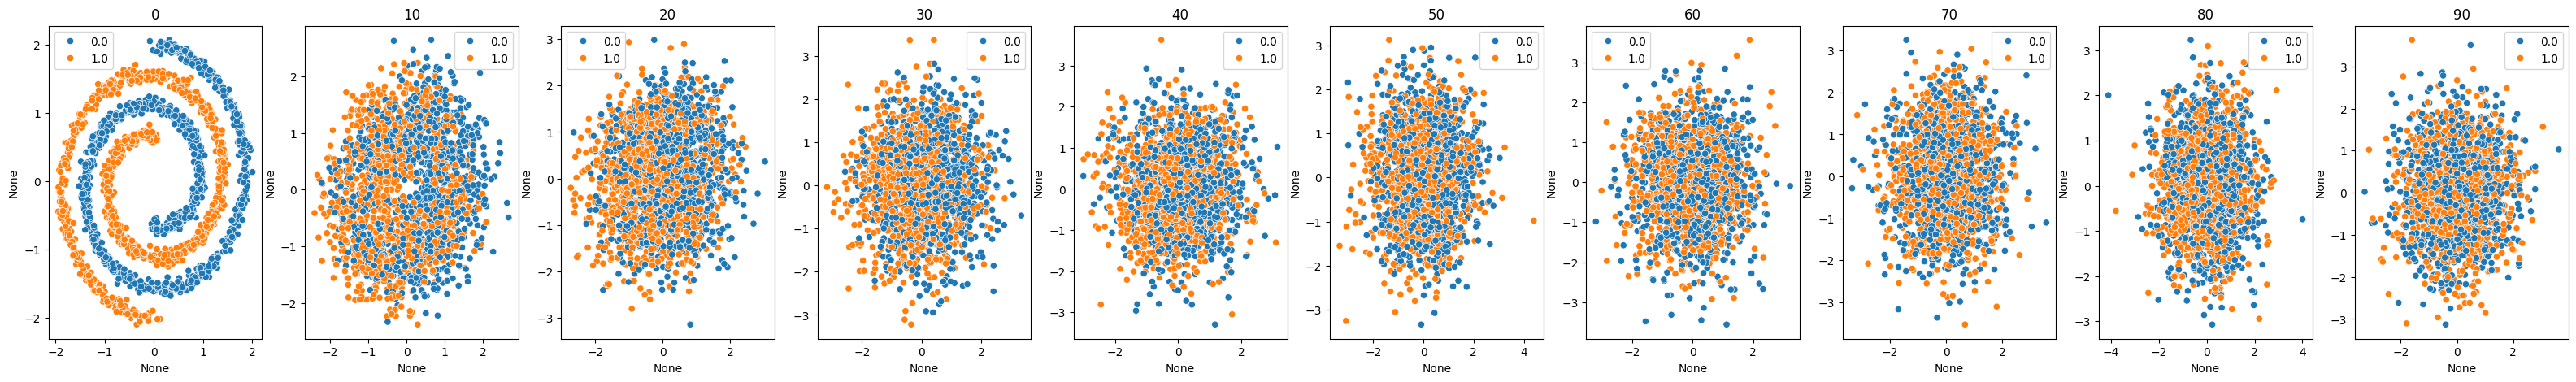

In [13]:
show_noising(diffusion, X, y)

### Модель (0.1 балл из 0.6 за DDPM)

Тут мы реализуем модель с весами $\theta$, которая параметризует обратный процесс. Модель не должна быть сложной и большой. Достаточно только линейных слоев. Не забудьте учесть классы $y$ и шаги $t$. Модель предсказывает шум $\epsilon: \epsilon_{\theta}(x_t, t, y)$

In [14]:
class DiffModel(nn.Module):
    def __init__(self, d_in, num_classes=2, T = 100):
        super().__init__()

        self.hidden = 128

        self.x_proj = nn.Linear(d_in, self.hidden)
        self.t_proj = nn.Embedding(T, self.hidden)
        self.y_embed = nn.Embedding(num_classes, self.hidden)
        self.layers = nn.Sequential(
            nn.Linear(self.hidden, self.hidden),
            nn.SiLU(),
            nn.Linear(self.hidden, d_in)
        )

    def forward(self, x, t, y):
        '''
        :x input, e.g. images
        :t 1d torch.LongTensor of timesteps
        :y 1d torch.LongTensor of class labels
        '''
        x = self.x_proj(x) + self.t_proj(t) + self.y_embed(y)
        return self.layers(x)

### Обучение модели (0.1 балл из 0.6 за DDPM)

Наконец, обучим нашу модель. Ниже за вас написан класс `Trainer`, который хранит модель, диффузию и оптимайзер. Вам надо лишь дописать функцию `_run_step`

In [15]:
from copy import deepcopy

import pandas as pd


class Trainer:
    def __init__(
        self,
        diffusion: Diffusion,
        model: nn.Module,
        train_iter,  # iterable that yields (x, y)
        lr: float,
        weight_decay: float,
        steps: int,
        device: torch.device = torch.device("cpu"),
    ):
        self.diffusion = diffusion

        self.train_iter = train_iter
        self.steps = steps
        self.init_lr = lr
        self.model = model
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=lr, weight_decay=weight_decay
        )
        self.device = device
        self.log_every = 100
        self.print_every = 500

    def _anneal_lr(self, step: int):
        """
        Performs annealing of lr.
        """

        frac_done = step / self.steps
        lr = self.init_lr * (1 - frac_done)
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

    def _run_step(self, x: torch.FloatTensor, y: torch.LongTensor):
        """
        A single training step.
        Calculates loss (using Diffusion.train_loss() )for a single batch.
        Then performs a single optimizer step (don't forget to zero grad) and returns loss.
        """
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = self.diffusion.train_loss(self.model, x, y)
        loss.backward()
        self.optimizer.step()
        return loss

    def run_loop(self):
        """
        Training loop.
        """
        step = 0
        curr_loss_gauss = 0.0

        curr_count = 0
        while step < self.steps:
            x, y = next(self.train_iter)
            batch_loss = self._run_step(x, y)

            self._anneal_lr(step)

            curr_count += len(x)
            curr_loss_gauss += batch_loss.item() * len(x)

            if (step + 1) % self.log_every == 0:
                gloss = np.around(curr_loss_gauss / curr_count, 4)
                if (step + 1) % self.print_every == 0:
                    print(f"Step {(step + 1)}/{self.steps} Loss: {gloss}")
                curr_count = 0
                curr_loss_gauss = 0.0

            step += 1

Теперь обернем наши данные в `DataLoader`. Для этого за вас написан `FastTensorDataLoader`. Также у нас идет обучение не по эпохам, а по итерациям, поэтому нам нужен "бесконечный" итератор.

In [17]:
def get_data_iter(X: np.ndarray, y: np.ndarray, batch_size: int = 512):
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).long()
    dataloader = FastTensorDataLoader(X, y, batch_size=batch_size, shuffle=True)
    while True:
        yield from dataloader


data_iter = get_data_iter(X, y)

In [18]:
# you can change hyperparameters
model = DiffModel(d_in=2)
model.device = torch.device("cpu")  # достаточно cpu
trainer = Trainer(
    diffusion, model, train_iter=data_iter, lr=0.001, weight_decay=0.0, steps=10000
)

In [ ]:
trainer.run_loop()  # < 1min

Теперь насэмплируем данные из нашей модели

In [34]:
from typing import List, Tuple


def sample_synthetic(
    diffusion: Diffusion,
    model: nn.Module,
    num_samples: int,
    batch: int = 1000,
    shape: Tuple = (2,),
    y_dist: List[float] = [0.5, 0.5],
    ddim: bool = False,
):
    sample_func = diffusion.p_sample_loop
    if ddim:  # for the last task
        sample_func = diffusion.ddim_sample
    res_x = []
    res_y = []
    num_sampled = 0
    while num_sampled < num_samples:
        x, y = diffusion.p_sample_loop(
            model, shape=(batch, *shape), y_dist=torch.tensor(y_dist)
        )
        res_x.append(x.cpu())
        res_y.append(y.cpu())
        num_sampled += batch

    res_x = torch.cat(res_x, dim=0)
    res_y = torch.cat(res_y, dim=0)
    return res_x[:num_samples], res_y[:num_samples]

In [30]:
Xs, ys = sample_synthetic(diffusion, model, 1000)

100%|██████████| 100/100 [00:00<00:00, 1312.03it/s]


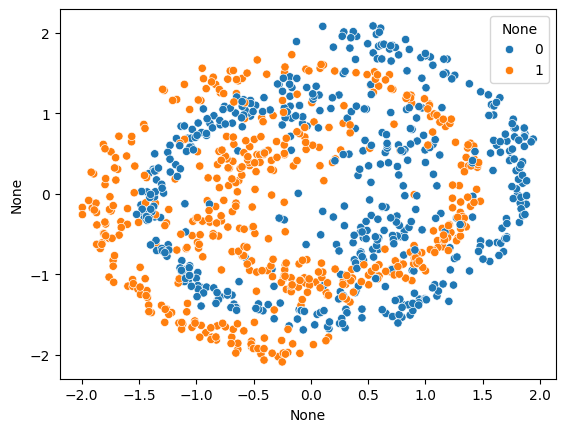

In [ ]:
sns.scatterplot(x=Xs[:, 0], y=Xs[:, 1], hue=ys)

Оцените на глаз, что получилось (должно быть неплохо). Как можно численно оценить качество насэмплированных данных (именно этих данных)?  Пункт не оценивается.

Покажите процесс расшумления аналагично тому, как мы это делали для прямого процесса

In [55]:
def show_denoising(diffusion, X, y):
    fig, axs = plt.subplots(1, 10, figsize=(40, 5))
    x = torch.from_numpy(X).float()
    y = torch.from_numpy(y).to(int)
    for i, t in enumerate(list(range(diffusion.num_timesteps))[::-1]):
        with torch.no_grad():
            model_output = model(x, torch.tensor([t] * x.shape[0], device=x.device, dtype=int), y)
            out = diffusion.p_sample(
                    model_output,
                    x,
                    torch.tensor([t] * x.shape[0], device=x.device, dtype=int)
                )
            x = out["sample"]
        if t % 10 == 1:
            sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, ax=axs[-t // 10])
            axs[-t // 10].set(title=t)

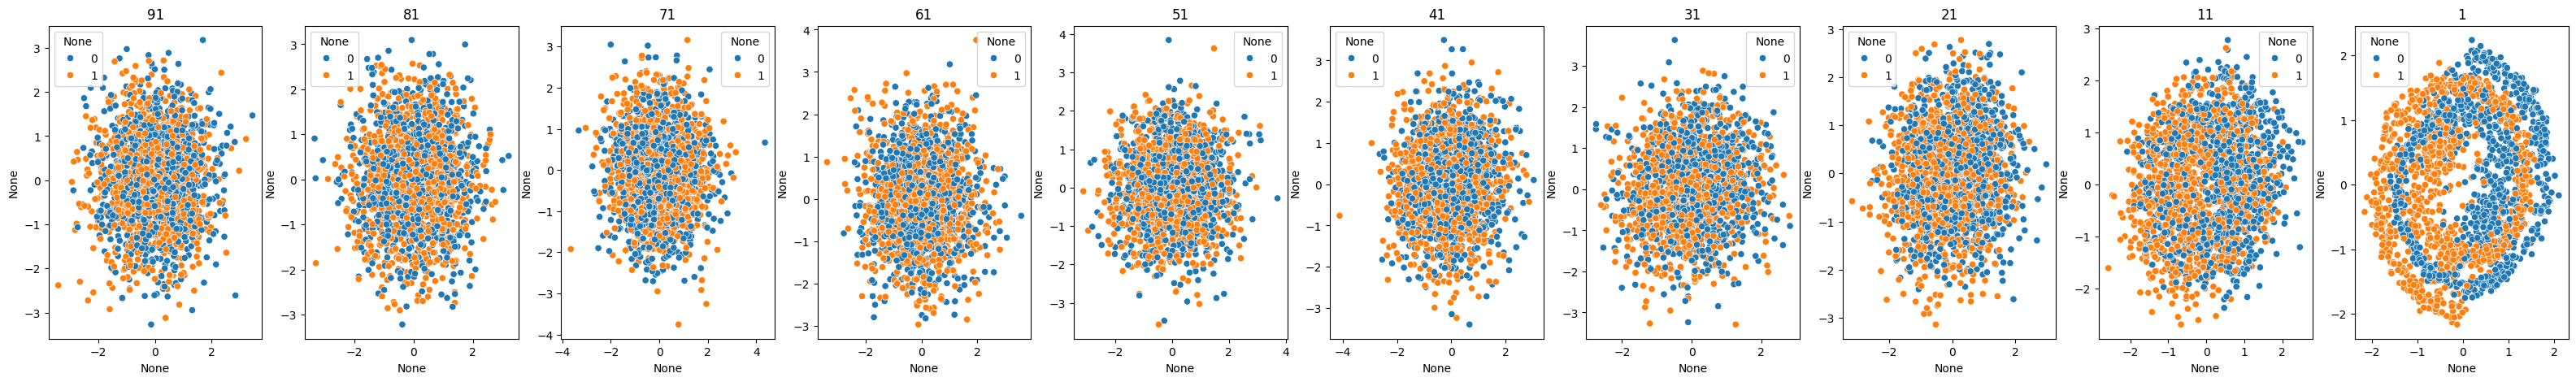

In [56]:
show_denoising(diffusion, X, y)

## MNIST (0.2 балла)

Перейдём к обучению диффузионной модели на MNIST. За вас уже написана архитектура модели. В данной задаче надо лишь получить относительно *хороший* результат на датасете, используя класс `Diffusion`, а также посмотреть на разные расписания шума.

In [19]:
from torch.utils.data import DataLoader


class InfiniteDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Initialize an iterator over the dataset.
        self.dataset_iterator = super().__iter__()

    def __iter__(self):
        return self

    def __next__(self):
        try:
            batch = next(self.dataset_iterator)
        except StopIteration:
            # Dataset exhausted, use a new fresh iterator.
            self.dataset_iterator = super().__iter__()
            batch = next(self.dataset_iterator)
        return batch

In [20]:
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import Compose, Lambda, Normalize, ToTensor

transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = InfiniteDataLoader(dataset, 512, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.26MB/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 244kB/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 1.68MB/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.87MB/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [21]:
def show_images(images, ys, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()
        ys = ys.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                plt.title(f"{int(ys[idx])}")
                plt.tick_params(bottom=False, labelbottom=False)
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()


def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0][:16], batch[1][:16], "Images in the first batch")
        break

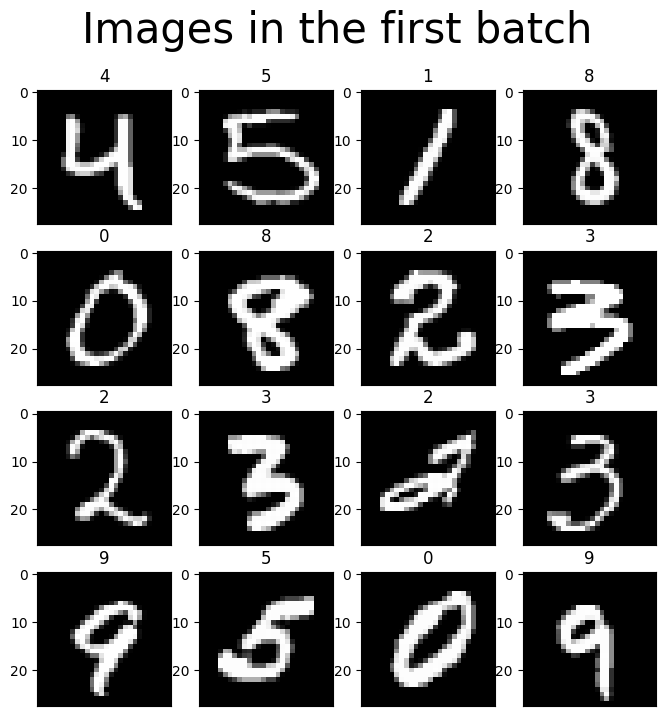

In [22]:
show_first_batch(loader)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    f"Using device: {device}\t"
    + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU")
)

Using device: cuda	NVIDIA A100-SXM4-80GB


In [24]:
model_mnist = MyUNet().to(device)
model_mnist.device = device

### Смотрим на расписание шума

Прежде чем начать, постройте на одной картинке графики $\sqrt{\bar{\alpha_t}}$ (относительно $t$) для различных расписаний (linear, quad, sigmoid). Объясните, чем они отличаются. Чтобы лучше это понять визуализируйте зашумление картинок (функция `show_noising_mnist`). Советую выбрать $T = 1000$ (классический выбор, если домен -- картинки). Данный пункт оценивается.

In [25]:
def get_alpha_bar(betas):
    alphas = 1 - betas
    return torch.cumprod(alphas, dim=-1).sqrt()

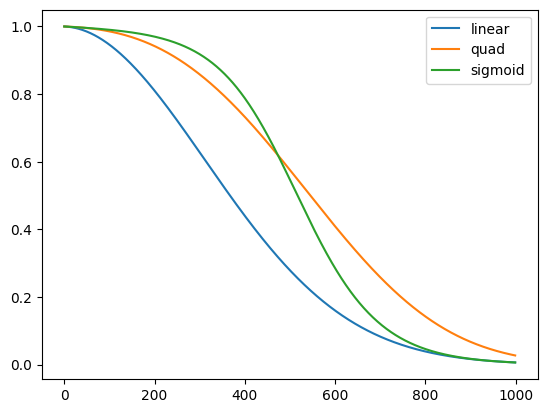

In [26]:
ts = range(1000)

for sch in ["linear", "quad", "sigmoid"]:
    plt.plot(ts, get_alpha_bar(torch.tensor(get_named_beta_schedule(sch, len(ts)))))

plt.legend(["linear", "quad", "sigmoid"])

In [27]:
# almost the same as in the task with SwissRolls

def show_noising_mnist(diffusion, img):
    fig = plt.figure(figsize=(4, 4))
    img = diffusion.q_sample(x_start=img, t=torch.tensor([400]))
    plt.imshow(img[0], cmap="gray")
    plt.show()

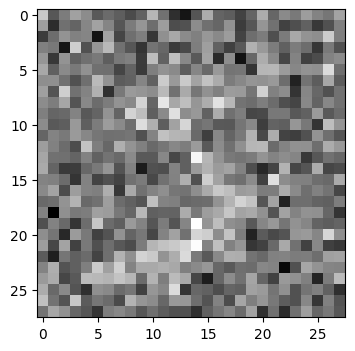

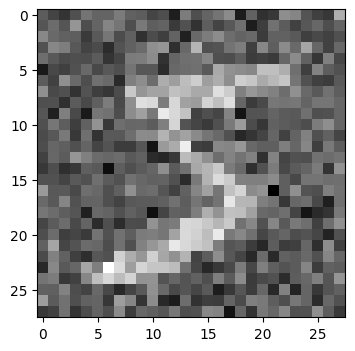

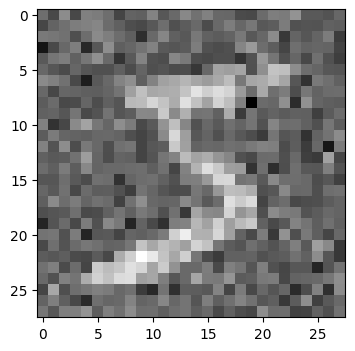

In [28]:
for sch in ["linear", "quad", "sigmoid"]:
    diffusion_temp = Diffusion(
        betas=get_named_beta_schedule(sch, 1000), loss_type="mse"
    )
    show_noising_mnist(diffusion_temp, dataset[0][0])

Видно, что линейный достаточно быстро убивает картинку. При этом sigmoid долго запрягает, но быстро едет. Думаю, что идеальным вариантом будет quad, так как равномерно добавляет шум на всех временах. Хотя мб тут лучше sigmoid из-за того, что посередине задача самая сложная.

### Обучаем

In [31]:
scheduler = "quad"

diffusion_mnist = Diffusion(
    betas=get_named_beta_schedule(scheduler, 1000),
    loss_type="mse"
)

# feel free to change hyperaparameters

trainer_mnist = Trainer(
    diffusion_mnist,
    model_mnist,
    train_iter=loader,
    lr=0.001,
    steps=10000,
    weight_decay=0.0,
    device="cuda"
)

In [32]:
trainer_mnist.run_loop()  # <15min on 2080Ti for the author's solution

Step 500/10000 Loss: 0.0942
Step 1000/10000 Loss: 0.0737
Step 1500/10000 Loss: 0.0674
Step 2000/10000 Loss: 0.0625
Step 2500/10000 Loss: 0.0614
Step 3000/10000 Loss: 0.0592
Step 3500/10000 Loss: 0.0575
Step 4000/10000 Loss: 0.056
Step 4500/10000 Loss: 0.0556
Step 5000/10000 Loss: 0.0543
Step 5500/10000 Loss: 0.0539
Step 6000/10000 Loss: 0.0531
Step 6500/10000 Loss: 0.0527
Step 7000/10000 Loss: 0.0525
Step 7500/10000 Loss: 0.0521
Step 8000/10000 Loss: 0.0518
Step 8500/10000 Loss: 0.0515
Step 9000/10000 Loss: 0.0511
Step 9500/10000 Loss: 0.0508
Step 10000/10000 Loss: 0.051


In [35]:
Xs, ys = sample_synthetic(
    diffusion_mnist,
    model_mnist,
    num_samples=16,
    batch=16,
    shape=(1, 28, 28),
    y_dist=[0.1 for _ in range(10)],
)

100%|██████████| 1000/1000 [00:05<00:00, 197.59it/s]


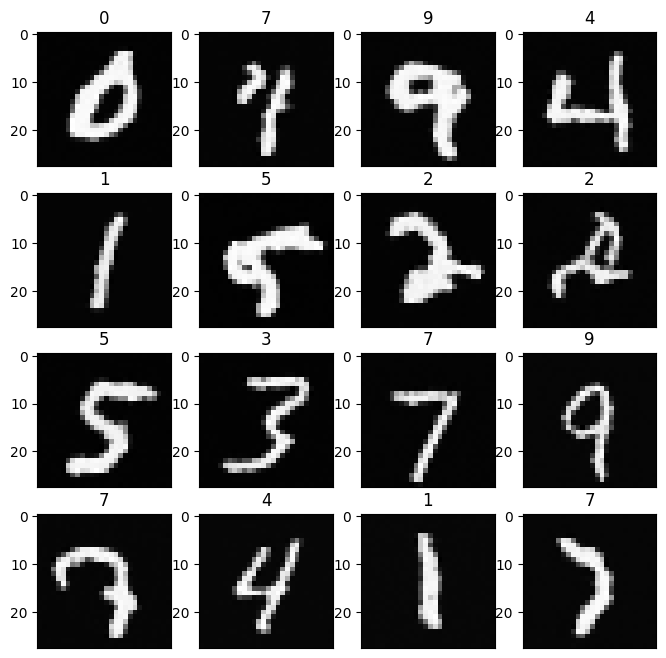

In [36]:
show_images(Xs, ys)

Оцените качество насэмплированных картинок.

## DDIM (0.2 балла)

**ВАЖНО:** В данном задании используется нотация из оригинальной статьи. Она отличается от нотации выше. А именно, считайте, что ниже $\alpha_t := \bar{\alpha}_t$ (в формулах, не в коде). Также $\sigma_t$ ниже тоже отличается (о том, что это, будет написано дальше).

В данной задаче вам предстоит реализовать DDIM сэмплирование. Подробнее читайте тут: [Denoising Diffusion Implicit Models, Song et al., 2020](https://arxiv.org/abs/2010.02502).

Давайте вкратце опишем, в чем смысл. Идея следущая: изменим диффузионный процесс так, чтобы используя предобученную DDPM, обратный процесс был детерминистичен и вследствии его можно было приближать за меньшее число шагов. В данном задании мы не будем ускорять процесс сэмплирования, но реализуем DDIM.

Чтобы не обучать новую модель, нам нужен прямой диффузионный процесс, у которого будет такая же функция потерь (MSE на шум), а обратный процесс все еще останется марковским. Оказалось, что существует целое семейство немарковских прямых процессов, удовлетворяющих этим требования. Это семейство имеет следующий вид (индуцируемое $\sigma \in \mathbb{R}^T$):

![ddim](https://i.imgur.com/lB2KaOR.png)

Среднее распределения выше было выбрано так, чтобы маргинальное распределение $q(x_t | x_0)$ оставалось таким же, как раньше. Это можно проверить, используя формулу Байеса и свойства нормальных распределений.  

То есть мы:
1. Ввели $q_{\sigma}(x_{t - 1} | x_t, x_0)$
2. Ввели его так, чтобы $q(x_t | x_0)$ было как раньше
3. При это прямой процесс становится не марковским $q_{\sigma}(x_t | x_{t - 1}, x_0)$
4. А обратный процесс марковский: $p(x_{t - 1} | x_t) = q_{\sigma}(x_{t - 1} | x_t, \hat{x_0}(x_t, t))$

Тогда обратный процесс можно переписать как $q_{\sigma}(x_{t-1}|x_t, \hat{x}_{0}(x_t))$ или же:

\begin{equation*}
    x_{t-1} = \sqrt{\alpha_{t-1}} \underbrace{\left(\frac{x_t - \sqrt{1 - \alpha_t} \epsilon_\theta^{(t)}(x_t)}{\sqrt{\alpha_t}}\right)}_{\text{`` predicted } x_0 \text{''}} + \underbrace{\sqrt{1 - \alpha_{t-1} - \sigma_t^2} \cdot \epsilon_\theta^{(t)}(x_t)}_{\text{``direction pointing to } x_t \text{''}} + \underbrace{\sigma_t \epsilon_t}_{\text{random noise}}  \quad \quad \quad \quad \quad \quad (8)
\end{equation*}

**Самое важное**:

Теперь давайте скажем, что $\sigma_t(\eta) = \eta\sqrt{(1 - \alpha_{t - 1}) / (1 - \alpha_t)}\sqrt{1 - \alpha_t / \alpha_{t - 1}}$, тогда при $\eta = 1$ равенство (8) превращается в DDPM сэмплирование. При $\eta = 0$ у нас $\sigma_t = 0$ и пропадает третья компонента стохастичности, что и называется DDIM сэмплирование. Таким образом, у нас есть детерминистичный процесс сэмплирования: при заданном начальном латенте мы всегда насэмлируем один и тот же $x_0$. Также можно достичь ускорения сэмплирования, выбирая лишь подмножество шагов $0 \leq \tau_1 \leq ... \leq \tau_S \leq T, \ \ \ S < T$ и сэмплируя с помощью DDIM по ним.

Итак, ниже вам придется реализовать прямой DDIM. Важно отметить, что нам не нужно переучивать модель, чтобы пользоваться DDIM.

In [37]:
class DiffusionWithDDIM(Diffusion):
    def __init__(self, *args, **kwargs):
        super(DiffusionWithDDIM, self).__init__(*args, **kwargs)

    @torch.no_grad()
    def ddim_step(
        self,
        model_out: torch.FloatTensor,
        x: torch.FloatTensor,
        t: torch.LongTensor,
        eta: float = 0.0
    ):
        """
        Performs ddim step. Use equation (8).
        """
        
        eps = model_out
        alpha_bar = _extract_into_tensor(self.alphas_cumprod, t, x.shape)
        alpha_bar_prev = _extract_into_tensor(self.alphas_cumprod_prev, t, x.shape)
        
        sigma = eta * torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar)) * torch.sqrt(1 - alpha_bar / alpha_bar_prev)
        
        mean_pred = alpha_bar_prev.sqrt() * (x - torch.sqrt(1 - alpha_bar) * eps) / alpha_bar.sqrt() + torch.sqrt(1 - alpha_bar_prev - sigma ** 2) * eps
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0
        noise = torch.randn_like(x)
        sample = mean_pred + nonzero_mask * sigma * noise

        return sample

    @torch.no_grad()
    def ddim_sample(
        self,
        model: nn.Module,
        shape: Tuple,
        y_dist: torch.FloatTensor,
        y: torch.LongTensor = None,
        noise: torch.FloatTensor = None,
        eta: float = 0.0
    ):
        """
        Performs ddim sampling.
        """
        if noise is None:
            x = torch.randn(shape)
        else:
            x = noise

        b = x.shape[0]
        if y is None:
            y = torch.multinomial(
                y_dist,
                num_samples=shape[0],
                replacement=True
            )


        device = x.device
        for t in reversed(range(self.num_timesteps)):
            print(f'Sample timestep {t:4d}', end='\r')
            t_array = (torch.ones(b, device=device) * t).long()
            model_out = model(x, t_array, y)
            x = self.ddim_step(
                model_out,
                x,
                t_array,
                eta=eta
            )
        print()
        return x

In [38]:
diffusion_ddim = DiffusionWithDDIM(
    betas=get_named_beta_schedule(scheduler, 1000), loss_type="mse"
)

Теперь насэмплируем детерминистично (eta = 0).

In [39]:
noise = torch.randn((16, 1, 28, 28))
Xs_new = diffusion_ddim.ddim_sample(
    model_mnist,
    shape=(1, 28, 28),
    y_dist=torch.tensor([0.1] * 10),
    noise=noise.to(model_mnist.device),
    y=ys.to(model_mnist.device)
)

Sample timestep    0


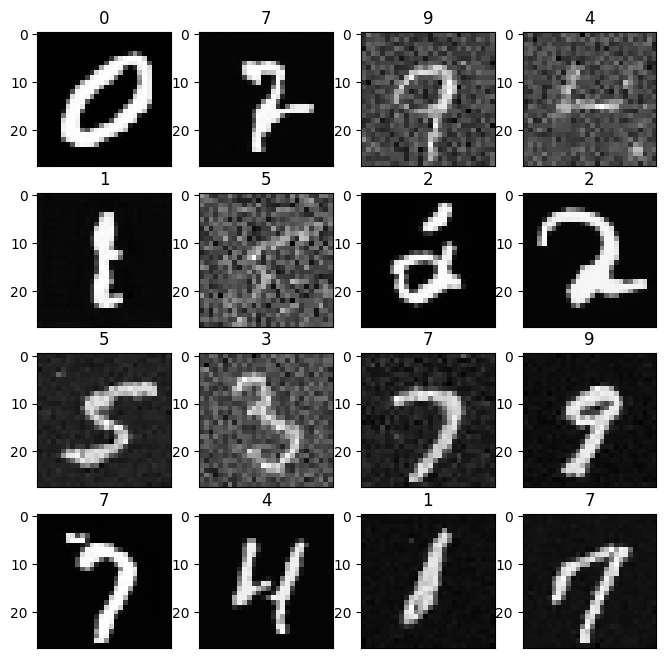

In [40]:
show_images(Xs_new, ys)

Оцените полученные сэмплы. DDIM хуже DDPM?

Качество хуже. Происходит это из-за того, что шум это своего рода регуляризация и он немного двигает траекторию генерации, поэтому картинки получаются довольно разнообразными(не детерминированная генерация) и более качественные.